In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
features = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']
df = df[features].copy()

<Axes: ylabel='Frequency'>

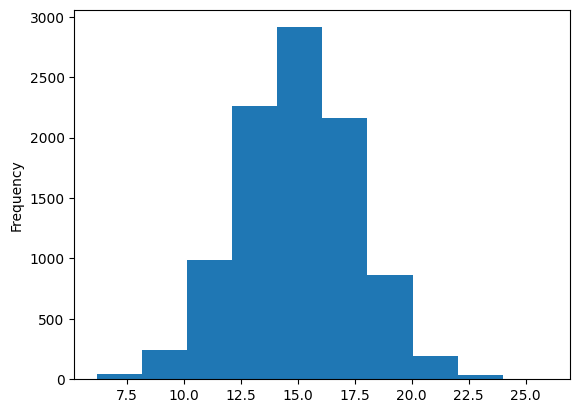

In [5]:
df.fuel_efficiency_mpg.plot(kind="hist")

In [6]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [7]:
df.horsepower.describe()

count    8996.000000
mean      149.657292
std        29.879555
min        37.000000
25%       130.000000
50%       149.000000
75%       170.000000
max       271.000000
Name: horsepower, dtype: float64

In [8]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
idx = np.arange(n)


In [9]:
def train_val_test_split(df, seed=42):
    np.random.seed(seed)
    np.random.shuffle(idx)
    df_train = (df.iloc[idx[:n_train]]).reset_index(drop=True)
    df_val = (df.iloc[idx[n_train:n_train+n_val]]).reset_index(drop=True)
    df_test = (df.iloc[idx[n_val:n_val+n_test]]).reset_index(drop=True)
    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values
    del df_train["fuel_efficiency_mpg"]
    del df_val["fuel_efficiency_mpg"]
    del df_test["fuel_efficiency_mpg"]
    return df_train, df_val, df_test, y_train, y_val, y_test

In [10]:
df_train, df_val, df_test, y_train, y_val, y_test = train_val_test_split(df)

In [11]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [12]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [13]:
def prepare_X(df):
    df = df.fillna(0)
    X = df.values
    return X

In [14]:
X_train = prepare_X(df_train)
w0,w1 = train_linear_regression(X_train, y_train)
X_val = prepare_X(df_val)
y_pred = w0 + w1.dot(X_val.T)
score = rmse(y_val, y_pred)

print("*"*100)
print("RMSE when null values replaced by 0 (Linear regression without regularization) - ",round(score,2))
print("*"*100)

****************************************************************************************************
RMSE when null values replaced by 0 (Linear regression without regularization) -  0.52
****************************************************************************************************


In [15]:
mean = df_train.horsepower.mean()
X_train = df_train.copy()
X_train.horsepower = X_train.horsepower.fillna(mean)

w0,w1 = train_linear_regression(X_train, y_train)

X_val = df_val.copy()
X_val.horsepower = X_val.horsepower.fillna(mean)

y_pred = w0 + w1.dot(X_val.T)
score = rmse(y_val, y_pred)

print("*"*100)
print("RMSE when null values replaced by mean (Linear regression without regularization) - ",round(score,2))
print("*"*100)


****************************************************************************************************
RMSE when null values replaced by mean (Linear regression without regularization) -  0.46
****************************************************************************************************


In [16]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [17]:
print("*"*100)
print("Linear regression with regularization - ")
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:

    X_train = prepare_X(df_train)
    w0,w1 = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val)
    y_pred = w0 + w1.dot(X_val.T)
    score = rmse(y_val, y_pred)
    
    print(f"RMSE when r is {r} - ",round(score,5))
    
print("*"*100) 

****************************************************************************************************
Linear regression with regularization - 
RMSE when r is 0 -  0.51738
RMSE when r is 0.01 -  0.51738
RMSE when r is 0.1 -  0.51738
RMSE when r is 1 -  0.51738
RMSE when r is 5 -  0.51738
RMSE when r is 10 -  0.51738
RMSE when r is 100 -  0.51738
****************************************************************************************************


In [18]:
scores = {}
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, df_test, y_train, y_val, y_test = train_val_test_split(df, seed)
    X_train = prepare_X(df_train)
    w0,w1 = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val)
    y_pred = w0 + w1.dot(X_val.T)
    score = rmse(y_val, y_pred)
    
    scores[seed] = score.item()

In [19]:
std = np.std(list(scores.values()))
round(std,3)

np.float64(0.007)

In [20]:
df_train, df_val, df_test, y_train, y_val, y_test = train_val_test_split(df, 9)
df_full_train = pd.concat([df_train,df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = prepare_X(df_full_train)


In [21]:
X_full_train

array([[ 240.        ,  105.        , 3495.1008121 , 2014.        ],
       [ 140.        ,  152.        , 3188.42278945, 2015.        ],
       [ 250.        ,  175.        , 3429.91489026, 2019.        ],
       ...,
       [ 230.        ,  120.        , 3233.0582363 , 2023.        ],
       [ 240.        ,  166.        , 3272.09625172, 2017.        ],
       [ 250.        ,  162.        , 2778.03107529, 2020.        ]],
      shape=(7764, 4))

In [22]:
y_full_train = np.concatenate([y_train, y_val])
y_full_train

array([12.42605359, 14.68591329, 13.22526268, ..., 13.32729324,
       13.38080669, 15.02800536], shape=(7764,))

In [23]:
w0, w1 = train_linear_regression_reg(X_full_train, y_full_train, 0.001)
w0, w1

(np.float64(28.884846306195094),
 array([ 8.84950850e-05,  3.47366685e-03, -5.01368206e-03,  3.22467479e-04]))

In [24]:
X_test = prepare_X(df_test)
y_pred = w0 + w1.dot(X_test.T)
score = rmse(y_pred, y_test)
score

np.float64(0.5144202220634425)